In [1]:
import torch
import mmseg

print("PyTorch version: ", torch.__version__)
print("MMSEG version: ", mmseg.__version__)

PyTorch version:  2.0.0
MMSEG version:  1.2.2


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
import mmcv

config_file = 'F:\AI_LAIA_STUFF\mmsegmentation\pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = 'F:\AI_LAIA_STUFF\mmsegmentation\pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = 'F:\AI_LAIA_STUFF\mmsegmentation\demo\demo.png'  # or img = mmcv.imread(img), which will only load it once
result = inference_model(model, img)
# visualize the results in a new window
show_result_pyplot(model, img, result, show=True)
# or save the visualization results to image files
# you can change the opacity of the painted segmentation map in (0, 1].
show_result_pyplot(model, img, result, show=True, out_file='result.jpg', opacity=0.5)
# test a video and show the results
# video = mmcv.VideoReader("F:/AI_LAIA_STUFF/mmsegmentation/video.mp4")
# for frame in video:
#   result = inference_model(model, frame)
#   show_result_pyplot(model, frame, result, wait_time=1)

Loads checkpoint by local backend from path: F:\AI_LAIA_STUFF\mmsegmentation\pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


array([[[ 87,  94,  87],
        [ 69,  80,  74],
        [ 94,  99,  99],
        ...,
        [ 86,  90,  80],
        [ 88,  91,  81],
        [ 86,  90,  80]],

       [[ 89,  96,  88],
        [ 73,  83,  76],
        [ 94,  99,  99],
        ...,
        [ 86,  90,  80],
        [ 88,  90,  79],
        [ 86,  90,  80]],

       [[ 87,  94,  87],
        [ 73,  83,  76],
        [ 94,  99,  99],
        ...,
        [ 86,  90,  80],
        [ 86,  88,  78],
        [ 86,  90,  80]],

       ...,

       [[ 88,  63,  91],
        [ 88,  63,  91],
        [ 88,  61,  90],
        ...,
        [102,  77, 102],
        [100,  76, 101],
        [102,  77, 102]],

       [[ 88,  61,  90],
        [ 88,  63,  91],
        [ 86,  61,  89],
        ...,
        [ 99,  73, 100],
        [100,  74, 100],
        [100,  74, 101]],

       [[ 88,  61,  90],
        [ 88,  63,  91],
        [ 86,  61,  89],
        ...,
        [ 90,  60,  88],
        [ 89,  62,  89],
        [ 92,  65,  92]]

# To check config of the model

In [1]:
from mmengine.config import Config

cfg = Config.fromfile('../mmsegmentation/configs/ocrnet/ocrnet_hr18_4xb2-160k_cityscapes-512x1024.py')
cfg.train_dataloader.batch_size = 4
print(cfg.model.decode_head)


[{'type': 'FCNHead', 'in_channels': [18, 36, 72, 144], 'channels': 270, 'in_index': (0, 1, 2, 3), 'input_transform': 'resize_concat', 'kernel_size': 1, 'num_convs': 1, 'concat_input': False, 'dropout_ratio': -1, 'num_classes': 19, 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 0.4}}, {'type': 'OCRHead', 'in_channels': [18, 36, 72, 144], 'in_index': (0, 1, 2, 3), 'input_transform': 'resize_concat', 'channels': 512, 'ocr_channels': 256, 'dropout_ratio': -1, 'num_classes': 19, 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 1.0}}]


# Load the model an try on image

In [22]:
from mmseg.apis import MMSegInferencer

inferencer = MMSegInferencer(model='resnest_s101-d8_fcn_4xb4-160k_ade20k-512x512')
inferencer('F:/AI_LAIA_STUFF/mmsegmentation/demo/demo.png', show=True)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/resnest/fcn_s101-d8_512x512_160k_ade20k/fcn_s101-d8_512x512_160k_ade20k_20200807_145416-d3160329.pth


{'predictions': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]], dtype=int64),
 'visualization': []}

# Proves

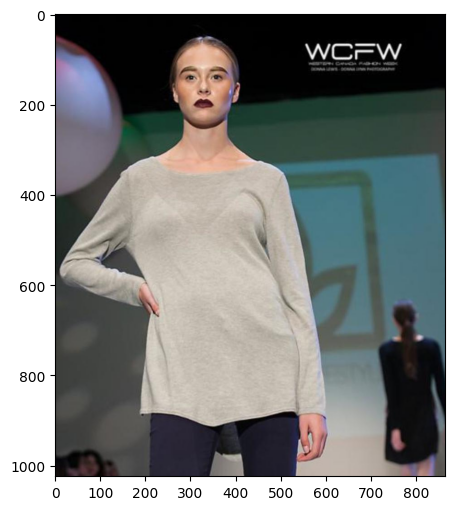

In [1]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
import numpy as np

img = mmcv.imread('../_data/fashionpedia/img_dir/train/0a3e75ac695e2a5673c9d1e1356e14a2.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [2]:
def generate_palette(num_classes, seed=42):
    """
    Generate a palette for MMSegmentation given the number of classes.

    Args:
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Palette array of shape (num_classes, 3).
    """
    np.random.seed(seed)
    palette = np.zeros((num_classes, 3), dtype=np.uint8)

    # Generate RGB colors
    for i in range(num_classes):
        r = np.random.randint(0, 256)
        g = np.random.randint(0, 256)
        b = np.random.randint(0, 256)
        palette[i] = [r, g, b]

    return palette

In [3]:
data_root = '../_data/fashionpedia'
img_dir = 'img_dir'
ann_dir = 'ann_dir'

classes = ('shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel')
palette = generate_palette(len(classes))

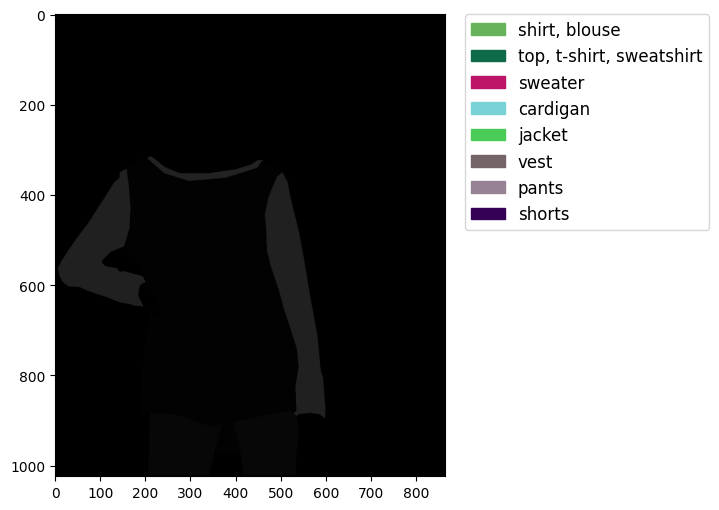

In [4]:
from PIL import Image
import matplotlib.patches as mpatches
img = Image.open('../_data/fashionpedia/ann_dir/train/0a3e75ac695e2a5673c9d1e1356e14a2_seg.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [5]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class FashionpediaDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

In [6]:
from mmengine import Config
cfg = Config.fromfile('../mmsegmentation/configs/ocrnet/ocrnet_hr18_4xb2-160k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=16000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1

In [7]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (192, 192)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head[0].num_classes = len(classes)
cfg.model.decode_head[1].num_classes = len(classes)

# Modify dataset type and path
cfg.dataset_type = 'FashionpediaDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(192, 192), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(192, 192), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'ann_dir/instances_attributes_train2020.json'
cfg.train_dataloader.num_workers = 1

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'ann_dir/instances_attributes_val2020.json'
cfg.val_dataloader.num_workers = 1

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.num_workers = 1

# Load the pretrained weights
cfg.load_from = 'ocrnet_hr18_512x1024_160k_cityscapes_20200602_191001-b9172d0c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../working'

cfg.train_cfg.max_iters = 1
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    192,
    192,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '../_data/fashionpedia'
dataset_type = 'FashionpediaDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=1, type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    

In [8]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/03 20:48:19 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 1650
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v.12.3
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-ge

c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\models\backbones\hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/03 20:48:22 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/03 20:48:22 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [9]:
runner.train()

OSError: [Errno 22] Invalid argument

In [10]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './working/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('../_data/img_dir/train/6000124.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

Loads checkpoint by local backend from path: ./working/iter_200.pth


FileNotFoundError: ./working/iter_200.pth can not be found.